<a href="https://colab.research.google.com/github/pranjalchaubey/Deep-Learning-Notes/blob/master/PyTorch%20Image%20Classification%20in%202020/Image_Classification_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification using PyTorch in 2020  

In this notebook we will be utilizing some of the latest advancements in the  
[PyTorch Ecosystem](https://pytorch.org/ecosystem/) to build a simple image classifier using CNNs.   

Along the way, we will learn some PyTorch and CNN (Convolution Neural  
Networks) basics. 

### 1. Get the Dataset Onboard

In any Machine Learning/Data Science problem, the first step is always to get  
the dataset.  

In our case, to get things started, we will initially use the simple [MNIST Dataset](https://en.wikipedia.org/wiki/MNIST_database).  
MNIST is largely considered the _'Hello World!'_ of AI/ML. The dataset was  
created way back in the late 90s. The [official description](http://yann.lecun.com/exdb/mnist/) states,  

_"The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image._  

_It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting."_  

<br/>You might be wondering, how to get this dataset in our Colab Workspace?  
PyTorch comes with a _datasets_ module called, [Torchvision.Datasets](https://pytorch.org/docs/stable/torchvision/datasets.html).  
Torchvision.Datasets module contains a number of publically available datasets  
including the one we are looking for, MNIST. You are encouraged to explore the  
Torchvision.Datasets documentation page. 

In [0]:
# Lets import some libraries 
import torch # PyTorch 
from torchvision import datasets # Datasets module 
import torchvision.transforms as transforms # Image Transforms 
from torch.utils.data.sampler import SubsetRandomSampler # Sampler 

In [0]:
# The Data Science Regulars
import numpy as np 
import pandas as pd

Checking out the torchvision.datasets module documentation, we find  
![Torchvision.Dataset](https://drive.google.com/uc?id=1Zsgc5_PnO9BQQ5wqssf67A5Ge-qIXtLh)



In [0]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,    # train=true => training set 
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,    # train=false => test set 
                                  download=True, transform=transform)

### 2. Train Validation Test Split 

Once the download is complete (usually instantaneous), you should be able to  
see the MNIST dataset downloaded inside the _'data'_ folder on the left hand  
side. (Click on the _Files_ icon on the left sidebar)  

We have both the training and the test sets. Now we need to bifurcate the   
training set in two parts,  
1. Training Set (80% images)
2. Validation Set (20% images)  

The algorithm we use to do this is quite simple,  
1. Create a list of indices of the training data 
2. Randomly Shuffle those indices 
3. Slice the indices in 80-20 split 

[Why create a _Validation Set_ at all?](https://datascience.stackexchange.com/questions/18339/why-use-both-validation-set-and-test-set) 

In [4]:
# obtain training indices that will be used for validation

# 1. Create a list of indices of the training data  
num_train = len(train_data)
print('num_train = len(train_data) ==> ', num_train)
indices = list(range(num_train))
print('len(indices) ==>', len(indices))
# print(indices)

num_train = len(train_data) ==>  60000
len(indices) ==> 60000


In [0]:
# 2. Randomly Shuffle those indices
np.random.shuffle(indices)

In [6]:
# 3. Slice the indices in 80-20 split
# percentage of training set to use as validation
valid_size = 0.2 # ie Train Set divided into two parts 
                 # 80% Train 20% Validation 
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

print('len(train_idx) ==> ', len(train_idx))
print('len(valid_idx) ==> ', len(valid_idx))

len(train_idx) ==>  48000
len(valid_idx) ==>  12000


Please Note that so far we have just been fiddling around with the _'indices'_,  
not the actual images as such.....but Why?  
Answer below.  

### 3. Prepare the Dataloaders 

By now, we have downloaded the dataset, and created a train/valid/test split.  
Q: How do we _'push'_ this data into a PyTorch model?  
A: PyTorch has a mechanism to _'ingest'_ data from a dataset through a module  
known as `DataLoader`.  

A great analogy,  
![DataLoader](https://drive.google.com/uc?id=1U4IG-5lbFGQQS4xwQPU2QiYdR1hFGBZ5)

[Great tutorial on DataLoaders.](https://www.journaldev.com/36576/pytorch-dataloader)  
[Ultimate tutorial on DataLoaders.](https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel) 

Time to prepare the _DataLoaders_ now!  

![DataLoader Documentation](https://drive.google.com/uc?id=1YFbWIGwNlL5Kp4Zvt52Ck0_Wk4MNfxS9)

In [0]:
# define samplers for obtaining training and validation batches
# remember train_idx and valid_idx were the indices that we shuffled above
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare dataloaders
# number of subprocesses to use for data loading
num_workers = 0 # do not modify 
# how many samples per batch to load
batch_size = 20 # ie 20 images per batch 

# Training Set 
train_loader = torch.utils.data.DataLoader(dataset=train_data, \
                                           batch_size=batch_size, \
                                           sampler=train_sampler, \
                                           num_workers=num_workers)
# Validation Set 
valid_loader = torch.utils.data.DataLoader(dataset=train_data, \
                                           batch_size=batch_size, \
                                           sampler=valid_sampler, \
                                           num_workers=num_workers)
# Test Set 
# Notice we have not used a 'sampler' here as it was not required 
test_loader = torch.utils.data.DataLoader(dataset=test_data, \
                                          batch_size=batch_size, \
                                          num_workers=num_workers)

We got the dataloaders working, but how do we know that they are working indeed?  
Visualizing the data from the dataloaders would be a good check! 

In [10]:
# Visualize a whole batch of data from the dataloaders 

dataiter = iter(train_loader) # Get the whole batch 
images, labels = dataiter.next() # Extract the images and their labels 
print(len(images), len(labels)) # Should be equal to the batch size, 20
print('Correct Labels: ', labels)
images = images.numpy() # Convert the images to numpy array for matplotlib
print('Shape of our images tensor =', images.shape)
print('Batch Size =', images.shape[0], 'Image Height/Width =', \
                                                        images.shape[2])

print()
print('Squeezing the images tensor =', np.squeeze(images).shape)
print('Un-squeezing the images tensor (axis=3) =', \
                                        np.expand_dims(images, axis=3).shape)

20 20
Correct Labels:  tensor([4, 6, 1, 6, 4, 7, 3, 3, 7, 2, 7, 6, 9, 2, 8, 5, 9, 6, 6, 3])
Shape of our images tensor = (20, 1, 28, 28)
Batch Size = 20 Image Height/Width = 28

Squeezing the images tensor = (20, 28, 28)
Un-squeezing the images tensor (axis=3) = (20, 1, 28, 1, 28)


In [0]:
import matplotlib.pyplot as plt 
# Plots are plotted inside the notebooks, 'inline'
%matplotlib inline 

With matplotlib, always remember that _figures contain axes which in turn   
contain the plots_.  
![Real Python](https://drive.google.com/uc?id=1KdlAGoCK8Lj9pFkrZf52oqOJK3sH3JuH)  

[Great tutorial on Matplotlib.](https://realpython.com/python-matplotlib-guide/)

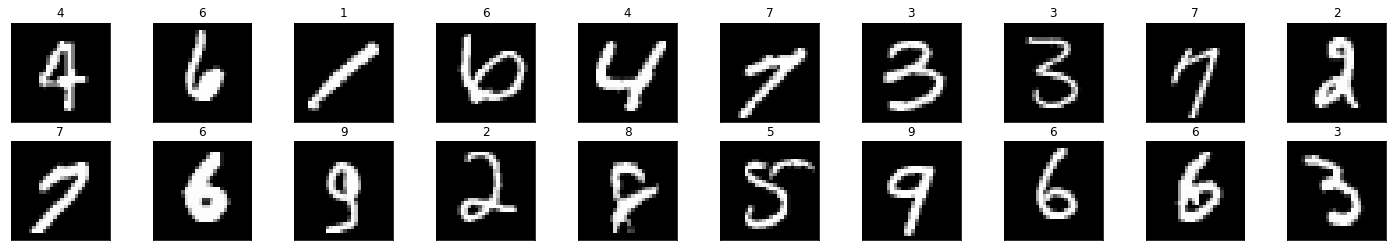

In [12]:
# Plot the whole batch 
fig = plt.figure(figsize=(25, 4))
# Loop over all the images in the batch(20)
for idx in np.arange(20):
    # Add a subplot for the image 
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    # Populate the subplot with the image 
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [13]:
# A neat little numpy trick
# Just for fun! 

dataiter = iter(train_loader)  
images, labels = dataiter.next() 
images = images.numpy() 
np.set_printoptions(precision=2, threshold=None, edgeitems=None, \
                    linewidth=180, suppress=None)
print('Label', labels[0])
print(images[0])

Label tensor(8)
[[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.26 0.58 0.65 0.9  1.   1.   0.78 0.38 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.16 0.47 0.91 0.98 0.99 0.97 0.72 0.72 0.72 0.89 0.98 0.52 0.   0.   0.   0.

Our dataloaders seem to be working fine and out data looks great!  
<br/> 
Time to build our CNN based image classification model in PyTorch.....in 2020! 

### 4. Build a PyTorch CNN Model
But first, we need to know how CNNs work and what are the components of a  
typical CNN based image classification architecture.  

![CNN Scan](https://media.giphy.com/media/vRINohj6YtmnkTQqHi/giphy.gif)


####4.1.1 CNN Architecture  
A typical CNN Architecture looks like this,  

![Block CNN Architecture](https://drive.google.com/uc?id=1RYYh27hsyY5Mx4L_lwGUVGQ3OYkSCqB- "https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53")  
<br/>A real life example of VGG-16,  

![VGG-16 Architecture](https://drive.google.com/uc?id=14OYg0ihFKHGsLQLcqoeSLt2nyPS4quss "https://www.researchgate.net/figure/The-architecture-of-a-VGG-16-network_fig2_330467052")  
<br/>Another example, very close to what we are going to build today,  

![MNIST CNN Architecture](https://drive.google.com/uc?id=1cnDzorKeRmNUAUJYw2yvQiY2D4f-sDNL "https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53")

####4.1.2 Basic CNN Layer  
So how does a CNN layer actually _'works'_?  

![CNN Scan](https://drive.google.com/uc?id=1JictobCPmaIX_9pm2mQewc4QiAzl0pzO "Remember Billie Eilish above?")  

<br/>A colored image has 3 channels,  
![RGB Image](https://drive.google.com/uc?id=1QlU04TZ6IN2IRqQJFB8m6GFJ2MmqYGhz "https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53")  

<br/>A 3-channel convolution,  
![RGB Convolution](https://drive.google.com/uc?id=1CGIqxGHjJGXr8aduPtwGd1-ikgA3WqJ5 "https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215")  

![RGB Convolution Summation](https://drive.google.com/uc?id=1fpM3NLvyjeiKF6_at0Nv4XhYPRkwH1IY "https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215")

####4.1.3 Stride  
_'Stride'_ of the kernel while scanning the image.  

Here's an example with _stride=1_,  
![CNN Stride = 1](https://drive.google.com/uc?id=1wJd7VCYfiMDes0Ex0SlBL97yBP6P7ajt "https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53")  

<br/>Another example with _stride=2_,  
![CNN Stride = 2](https://drive.google.com/uc?id=1dG2i4WtxUzu9Wlsl3jyH4ZXxUSYVdKfk)

####4.1.4 Padding  
Padding ensures that there is no loss of information while an image with a  
convolutional kernel.  
![Padding = 1](https://drive.google.com/uc?id=1xIQSJVRtAS7em_E387ZBd6sErjwA7RD6 "https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53")

####4.1.5 Max Pooling  
Max Pooling layer primarily reduces the dimensionality of the input.  

![Max Pooling](https://drive.google.com/uc?id=11_1ThNaU4e4DAEFs7I9GsNoD7oFmtVES "https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53")  

Max Pooling is not the only type of pooling layer out there.  
![Type of Pooling](https://drive.google.com/uc?id=1ECZrE8vAhTE1gEsp_3vPy03oLuSj0aOW)  

[A nice tutorial on pooling layers.](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/ "Json Brownlee is an absolute genius. His blog is a damn goldmine!") 

####4.1.6 Rectified Linear Units aka ReLU  
The non-linear activation function.  
![ReLU Activation](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2018/10/Line-Plot-of-Rectified-Linear-Activation-for-Negative-and-Positive-Inputs.png "https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/")

####4.1.7 _Fully Connected_ or _Linear Layers_  
Final dimensionality reduction for either classification or regression tasks.  

![Fully Connected Layers](https://drive.google.com/uc?id=1Fwh-NqMDLx-xqKlqN2c-z780M9aBUHvO "https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53") 

Before we move forward, a few questions for everyone:  
1. What kind of features do the first few CNN layers capture?  
2. What kind of features do the last few CNN layers capture? 
3. What is the role of max-pool?  
4. Can we use _stride_ to perform a role similar to max-pool?  
 

####4.2.1 PyTorch  
PyTorch is currently the hottest Deep Learning library out there. In terms of  
popularity, it has even taken over Tensorflow. Tensorflow came before PyTorch  
and is backed by the engineering and marketing might of _**Google**_.  

_Why PyTorch got so darn famous?_  
The answer lies in the fact that PyTorch is highly pythonic (due to dynamic  
computational graphs) which makes it extremely flexible and ideal for  
researchers and developers alike.   

####4.2.2 Understanding Computational Graphs   
At the bottom of every Deep Neural Network training, there are only two things  
taking place, 
1. A forward pass - pushing images/data from the start of the network and   
generating an output (and a loss/error).  
2. Backpropagation - essentially a backward pass where we calculate gradients  
using partial derivatives with respect to the loss, and make changes to the  
weights of the network. In a nutshell, this is how deep learning networks  
train.  

![A Computational Graph](https://drive.google.com/uc?id=1dgVg08M02gfIkPm0JKyhm4k4gYVLB_Me "Udacity Deep Learning Nano Degree")  
The image above, is a simple neural network. But it is also a   
computational graph.  

We first make a forward pass through our network and then a backward pass  
to calculate how much loss was being contributed by _**W1**_ weight in  
particular.  

Every neural network you define, PyTorch _sees_ it as a computational graph  
similar to what we see above and keeps a track of all the operations   
performed by every node. This ensures that it calculates accurate gradients  
when make a backward pass.  

Good thing about PyTorch is that it creates these computational graphs on the  
fly! And this aspect makes PyTorch and extremely felxible (and pythonic) deep  
learning library.   

![Dynamic Computational Graphs](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/09/dynamic_graph.gif "PyTorch building dynamic computational graphs on the fly")

####4.2.3 Tensors  
Tensors are the building blocks of every deep learning library including   
PyTorch. What are tensors though?  

![Tensors](https://drive.google.com/uc?id=1F5cLclu4RML7zj7axf8IGU7aUXJlI7N0 "Udacity Deep Learning Nano Degree")  

Creating tensors in PyTorch is easy  
```
import torch 
x = torch.rand(3, 3)
print(x)

>>Prints out:
>>tensor([[0.5264, 0.1839, 0.9907],
>>        [0.0343, 0.9839, 0.9294],
>>        [0.6938, 0.6755, 0.2258]])
```
Tensors in PyTorch are exactly like the numpy arrays, except that they can   
also live on a GPU which makes them realy really fast!  
```
torch.FloatTensor([[20, 30, 40], [90, 60, 70]]) # Tensor on CPU
torch.cuda.FloatTensor([[20, 30, 40], [90, 60, 70]]) # Tensor on GPU
```
Moving tensors (and complex deep learning models) to a GPU (or a CPU) is   
pretty straightforward in PyTorch. 
```
x = torch.FloatTensor([[20, 30, 40], [90, 60, 70]]) # Tensor on CPU
print('Is tensor x on GPU?', x.is_cuda) # False
x = x.to('cuda') # Moves to GPU
print('Is tensor x on GPU?', x.is_cuda) # True 
x = x.to('cpu') # Moves back to CPU
print('Is tensor x on GPU?', x.is_cuda) # False
```

####4.2.4 The Autograd Module  
Autograd is the real rockstar module in PyTorch.  
Autograd is the module that keeps a track of all the operations performed on a  
tensor and calculates the gradients through a technique called _**Automatic  
Differentiation**_  

To enable tracking computation history on a tensor, set _**`.requires_grad`**_  
to _**`True`**_. To detach a tensor from its computation history, call   
_**`.detach()`**_.  

In order to stop autograd from keeping history of computations on a deep  
learning model, wrap it around _**`torch.no_grad():`**_. This is usually done  
during inference. 
```
with torch.no_grad():
    # inference code 
``` 

####4.2.5 The nn.Module  
The nn module in PyTorch is used to 'build' the neural networks and contains  
all the deep learning layers. It obviously depends upon the autograd module to  
calculate gradients.  

When defining our custom models in PyTorch, we typically subclass the   
nn.Module class and override the `__init__()` and `forward()` functions.  
1. `__init__()` - This is where we define the layers of our network. 
2. `forward()` - This is where you actaully connect the layers together and  
make everything work.  

Don't worry if this sounds a little confusing, we will be seeing `nn.Module`   
in action very soon! 



####4.2.6 The Optim Package  
The optim package in PyTorch contains the optimization algorithms that help   
to train your network.  

A simple example,  
`optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)`  

<br/>[My all time favorite 'Intro to PyTorch' tutorial](https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e "Understanding PyTorch with an example: a step-by-step tutorial")  
[Great PyTorch Tutorial Part 1](https://blog.paperspace.com/pytorch-101-understanding-graphs-and-automatic-differentiation/ "PyTorch 101, Part 1: Understanding Graphs, Automatic Differentiation and Autograd")  
[Great PyTorch Tutorial Part 2](https://blog.paperspace.com/pytorch-101-building-neural-networks/ "PyTorch 101, Part 2: Building Your First Neural Network")  
[Great PyTorch Tutorial Part 3](https://blog.paperspace.com/pytorch-101-advanced/ "PyTorch 101, Part 3: Going Deep with PyTorch")  
[Great PyTorch Tutorial Part 4](https://blog.paperspace.com/pytorch-memory-multi-gpu-debugging/ "PyTorch 101, Part 4: Memory Management and Using Multiple GPUs")  
[Great PyTorch Tutorial Part 5](https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/ "PyTorch 101, Part 5: Understanding Hooks")  
[Stunning Insight into the Internals of PyTorch](http://blog.ezyang.com/2019/05/pytorch-internals/ "PyTorch Internals")

####4.3 Time to define our model!  
But before we start off with the model definition, let's have a look at what  
the PyTorch Documentation says about the Convolutional NNs.  

![Conv2d Layer](https://drive.google.com/uc?id=1odHZIXURYjogjUcyCQ56RYfQPqgzO7DX "Conv2D")  

<br/>We also need to check out about the MaxPool, Dropout and Linear Layers.  

![MaxPool 2D](https://drive.google.com/uc?id=1r1EeLHrV5oAG4OUyRSm0lw2OcZyJQ7ne "MaxPool2D Layer")  

![Dropout Layer](https://drive.google.com/uc?id=1kYgb4wDrGEBEF5WB169N7Q5hTrwDDO1d "Dropout Layer")  

![Linear Layer](https://drive.google.com/uc?id=1rrIEqPtun_8Td1js76B2hv22Xm5tjY6m "Linear Layer")  

Did you guys notice a weird anomaly in the Conv2d and Linear layers?  
```
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
```  
```
torch.nn.Linear(in_features, out_features, bias=True)
```

Conv2d layer expects `in_channels` while the Linear layer expects `in_features`.  

Bottom line is, that PyTorch expects different things from a tensor dimension.  
Specifically,  
```
"""Example tensor size outputs, how PyTorch reads them, and where you encounter them in the wild. 
Note: the values below are only examples. Focus on the rank of the tensor (how many dimensions it has)."""
>>> torch.Size([32])
    # 1d: [batch_size] 
    # use for target labels or predictions.
>>> torch.Size([12, 256])
    # 2d: [batch_size, num_features (aka: C * H * W)]
    # use for as nn.Linear() input.
>>> torch.Size([10, 1, 2048])
    # 3d: [batch_size, channels, num_features (aka: H * W)]
    # when used as nn.Conv1d() input.
    # (but [seq_len, batch_size, num_features]
    # if feeding an RNN).
>>> torch.Size([16, 3, 28, 28])
    # 4d: [batch_size, channels, height, width]
    # use for as nn.Conv2d() input.
>>>  torch.Size([32, 1, 5, 15, 15])
    # 5D: [batch_size, channels, depth, height, width]
    # use for as nn.Conv3d() input.
```    

A neat method to make your tensors ready for the linear layer,  
```
Use view() to change your tensor’s dimensions.

image = image.view(batch_size, -1)

You supply your batch_size as the first number, and then “-1” basically tells Pytorch, “you figure out this other number for me… please.” 
Your tensor will now feed properly into any linear layer.
```

[Incredible Tutorial on PyTorch Layer Dimensions.](https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd)

Before we start,  
1. What is the shape (dimensions) of our images?  
2. What is the size of our batch? 
3. How many _'channels'_ are there in our images? 

In [0]:
import torch.nn as nn # nn module contains all the layers 
import torch.nn.functional as F # same as nn, but a little different 

In [0]:
# Our CNN based neural architecture 
# Let's build a simple one with only Convolutional, Linear 
# and dropout layers
class MNISTModel1(nn.Module):
    # Here we define the neural architecture 
    def __init__(self):
        super(MNISTModel1, self).__init__() # Initialize the nn module 
        
        # Convolutional Layers
        # What shape/dimensions the first layer is going to see? 
        # Do we need to have some padding for a kernel_size = 3?  
        # Input Features = 1 x 28 x 28
        # Output Features = ???
        # Shape of a Convolutional Layer = (W - K + 2P)
        #                                  ------------ + 1
        #                                       S
        # where, 
        #       W = Width/Height of previous layer = 28
        #       K = Filter Size = 3
        #       P = Padding = 0
        #       S = Stride = 1(default)
        # Therefore, 
        #           if padding = 0
        #           Output Shape = ((28 - 3 + 2*0)/1)+1 = 26 
        # We want the dimensions to stay the same so that there is no 
        # loss of information when performing the convolution. 
        # Hence, 
        #       if padding = 1
        #       Output Shape = ((28 - 3 + 2*1)/1)+1 = 28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, \
                               stride=1, padding=1) # Output Features = 8 x 28 x 28  
        # Input Features = 8 x 28 x 28
        # Output Features = 16 x 28 x 28 | ((28 - 3 + 2*1)/1)+1 = 28
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, \
                               stride=1, padding=1)

        # Linear Layers 
        # What shape the first linear layer is going see?
        # What are the total number of features given out by conv2?
        # Features = 16 x 28 x 28 = 12544
        # Therefore,           
        self.linear1 = nn.Linear(in_features=12544, out_features=256)
        self.linear2 = nn.Linear(in_features=256, out_features=64)
        # Last linear layer should output 10 features as we are 
        # Classifying the images in 10 categories 
        self.linear3 = nn.Linear(in_features=64, out_features=10)

        # Dropout 
        self.dropout = nn.Dropout(p=0.25)

    # Here we define the 'forward behaviour' of our neural architecture 
    def forward(self, image_batch):
        # This is also the place where we add ACTIVATION functions 
        image_batch = F.relu(input=self.conv1(image_batch))          
        image_batch = F.relu(input=self.conv2(image_batch))  
        
        # Remember that when passing image_batch through the Linear layers, 
        # PyTorch expects: 
        # >>> torch.Size([12, 256]) -> example values 
            # 2d: [batch_size, num_features (aka: C * H * W)]
            # use for nn.Linear() input.   
        # Therefore, we need to 'flatten' image_batch
        # image_batch = image_batch.view(batch_size, -1) --> batch size ???
        flat_image_batch = image_batch.view(image_batch.shape[0], -1)
        flat_image_batch = F.relu(input=self.linear1(flat_image_batch))
        # Let's add the dropout too 
        flat_image_batch = self.dropout(F.relu(input=self.linear2(flat_image_batch)))
        # Final Layer of the network 
        flat_image_batch = F.relu(input=self.linear3(flat_image_batch))
        # The output from the final layer is a tensor with 10 'logits'
        return flat_image_batch               

Now that we have defined our model, is there a way we can peep inside to see  
what is going on and that if everything is alright?  

Say hello to _**[torchsummary !!!](https://github.com/sksq96/pytorch-summary)**_ 

In [16]:
# Let's install torchsummary and do some cool stuff 
!pip install torchsummary # https://github.com/sksq96/pytorch-summary 

In [0]:
from torchsummary import summary 

In [18]:
# We can make the use of torchsummary library here to figure 
# if we have done something wrong 

# But first we need to tell PyTorch where to 'keep' the model 
# On GPU or on CPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print('The model will run on', device)

# Initialize the model 
mnist1 = MNISTModel1().to(device)
summary(model=mnist1, input_size=(1, 28, 28), batch_size=20) # Summarize

The model will run on cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [20, 8, 28, 28]              80
            Conv2d-2           [20, 16, 28, 28]           1,168
            Linear-3                  [20, 256]       3,211,520
            Linear-4                   [20, 64]          16,448
           Dropout-5                   [20, 64]               0
            Linear-6                   [20, 10]             650
Total params: 3,229,866
Trainable params: 3,229,866
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 2.93
Params size (MB): 12.32
Estimated Total Size (MB): 15.31
----------------------------------------------------------------


That was a lot of work.....Whew!  

_***Q: Isn't there an 'easier' way to define the Model in 2020?***_  
A: _**Yes, absolutely!**_  
Say hello to the _**[torchlayers library !!!](https://github.com/szymonmaszke/torchlayers)**_  
With torchlayers, the above code will be reduced to about 7-8 lines!  
But unfortunately, [torchlayers requires Python 3.7](https://github.com/szymonmaszke/torchlayers/issues/5) and above. Colab only  
supports Python 3.6.x. 



With our model definition complete, it is time to train! 

### 5. Train a PyTorch Model in 2020  

PyTorch is infamous among newcomers for it's _'training loops'_.  
They can be long and at times a little confusing too. However, most of them   
are similar and writing training loops simply turns out to be a boring and repetitive  
exercise.  

Q: _**This is 2020.**_ Is there a better way?  
A: _**Yes, absolutely!**_  
Say hello to _**[Poutyne !!!](https://poutyne.org/index.html)**_   


Thanks to _Poutyne_, writing training loops in PyTorch is _**FUN !!!**_  

PS - Poutyne is pronounced as Poutine or Pu-tin.  
![Poutyne](https://drive.google.com/uc?id=142xYy_mJoPSk97SDicvn9zRNxHMpXDxz "You think loops are boring?!?!")

In [19]:
# Install Poutyne 
!pip install poutyne 

     |████████████████████████████████| 81kB 1.3MB/s 


In [0]:
from poutyne.framework import Model # The core datastructure of poutyne 
                                    # https://poutyne.org/model.html
from poutyne.framework import Callback # We will see it in action in a little while 
                                       # https://poutyne.org/callbacks.html# 

In [0]:
from torch import optim # Optimizer: we need it to train our network

In [0]:
# A pouytne training loop

# A few hyperparamters for the training loop 
learning_rate = 0.1
epochs = 3

def poutyne_train(pytorch_model):
    
    # Select the optimizer and the loss function 
    optimizer = optim.SGD(pytorch_model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()
    # Poutyne Model
    model = Model(pytorch_model, optimizer, loss_function, batch_metrics=['accuracy'])
    # Send the 'Poutyne model' on GPU/CPU whichever is available 
    model.to(device)
    # Train
    model.fit_generator(train_loader, valid_loader, epochs=epochs)
    # Test
    test_loss, test_acc = model.evaluate_generator(test_loader)
    print(f'Test:\n\tLoss: {test_loss: .3f}\n\tAccuracy: {test_acc: .3f}')

    return None

In [23]:
# Let's start the training guys!!! 
poutyne_train(mnist1)

Epoch 1/3 35.42s Step 2400/2400: loss: 0.319735, acc: 90.016667, val_loss: 0.096412, val_acc: 97.183333
Epoch 2/3 35.28s Step 2400/2400: loss: 0.079684, acc: 97.760417, val_loss: 0.068129, val_acc: 98.083333
Epoch 3/3 34.94s Step 2400/2400: loss: 0.048999, acc: 98.589583, val_loss: 0.062555, val_acc: 98.183333
Test:
	Loss:  0.047
	Accuracy:  98.440


_**CONGRATULATIONS !!! You just trained your first(?) CNN Model!**_   
The accuracy looks pretty decent as well! 


### 6. Understanding Overfitting 
Before we move any further we need to understand the concept of _**Overfitting**_  
in Machine Learning models.  
What is _**overfitting?**_  
![Fitting Examples](https://drive.google.com/uc?id=1gFOa5I24S7XDDep4WaVMIoivh9JvIp1Y "https://www.curiousily.com/posts/hackers-guide-to-fixing-underfitting-and-overfitting-models/")

We are always looking to ensure that our models have a low bias with a low  
variance.  
However, if we train for too long (too many epochs) our model will start to  
overfit.  

How do we identify that the model has started overfitting?  
![Overfitting](https://drive.google.com/uc?id=1q02q0ge0jldHJm8P_Hq6ECeIvaSlcc36 "https://mlexplained.com/2018/04/24/overfitting-isnt-simple-overfitting-re-explained-with-priors-biases-and-no-free-lunch/")  
Dotted vertical line is where we should either stop training the model (also  
known as _**Early Stopping**_) or we should have some logic in the training  
loop that _'saves'_ the model around that time while the training still  
continues. 

Our model will also overfit if it is too complex.  
For example (y-axis is different),  
![Complex Model](https://drive.google.com/uc?id=1vWHgknPrbXEQczdKMliB0RyVgYld3cGa "https://medium.com/@george.drakos62/cross-validation-70289113a072")  

<br/>Early stopping can save the day!  
![alt text](https://drive.google.com/uc?id=1HnBFMWZGHy0UFMUICKU25qBiB-4_G0Xn "https://www.jeremyjordan.me/deep-neural-networks-preventing-overfitting/")

A really nice matrix to identify if we are overfitting:  
![Overfitting Matrix](https://drive.google.com/uc?id=19bFHepjNgQ9kpqmQdMEW4lDJ-qXi5WF8 "https://hackernoon.com/memorizing-is-not-learning-6-tricks-to-prevent-overfitting-in-machine-learning-820b091dc42")  
While preparing the above matrix, the author has considered only two sets,  
training and testing (kinda Deep Learning _faux pass_!). Since we have a  
validation set as well, replace the word _**'Testing'**_ with  
_**'Validation'**_. 

How can we avoid _**Overfitting**_?  
1. Use a simpler model (less layers)  
2. Use _Dropout_ 
3. Get more training data (if possible) 
4. Augment the data and add noise  
5. Early Stopping  

PS - Not an exhaustive list AT ALL.  

<br/>Can we write a better training loop now? 

### 8. A Better Training Loop  
We combine our knowledge of Early Stopping and saving the model at the right  
time during training to write a better _Training Loop_.  

We use [Callbacks](https://poutyne.org/callbacks.html# "Click to visit link") in Poutyne to incorporate Early Stopping and saving the model after every epoch.

In [0]:
from poutyne.framework import ModelCheckpoint # Saves trained model during training
                                              # https://poutyne.org/callbacks.html#checkpointing
from poutyne.framework import EarlyStopping # You know what it does! ;) 
                                            # https://poutyne.org/callbacks.html#poutyne.framework.callbacks.EarlyStopping

In [0]:
# A better pouytne training loop
# Turn the GPU ON

# A few hyperparamters for the training loop 
learning_rate = 0.1
epochs = 10 # let's train for more epochs to see the callbacks in action

def better_poutyne_train(model_name, pytorch_model):
    
    callbacks = [
    # Save the latest weights 
    ModelCheckpoint(model_name + '_last_epoch.ckpt', \
                    temporary_filename='last_epoch.ckpt.tmp'),
    # EarlyStopping
    EarlyStopping(monitor='val_acc', patience=0, verbose=True, mode='max')
    ]
    
    # Select the optimizer and the loss function 
    optimizer = optim.SGD(pytorch_model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()
    # Poutyne Model
    model = Model(pytorch_model, optimizer, loss_function, batch_metrics=['accuracy'])
    # Send the 'Poutyne model' on GPU/CPU whichever is available 
    model.to(device)
    # Train
    model.fit_generator(train_loader, valid_loader, epochs=epochs, callbacks=callbacks)
    # Test
    test_loss, test_acc = model.evaluate_generator(test_loader)
    print(f'Test:\n\tLoss: {test_loss: .3f}\n\tAccuracy: {test_acc: .3f}')

    return None 

In [26]:
# Let's initialize a new CNN Model just like before 
mnist2 = MNISTModel1().to(device)
summary(model=mnist2, input_size=(1, 28, 28), batch_size=20) # Summarize

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [20, 8, 28, 28]              80
            Conv2d-2           [20, 16, 28, 28]           1,168
            Linear-3                  [20, 256]       3,211,520
            Linear-4                   [20, 64]          16,448
           Dropout-5                   [20, 64]               0
            Linear-6                   [20, 10]             650
Total params: 3,229,866
Trainable params: 3,229,866
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 2.93
Params size (MB): 12.32
Estimated Total Size (MB): 15.31
----------------------------------------------------------------


In [27]:
# Time to train in a better way!.....takes about 120secs on GPU 
# Make sure to Turn the GPU ON
better_poutyne_train(model_name='mnist2', pytorch_model=mnist2)

Epoch 1/10 35.84s Step 2400/2400: loss: 0.349615, acc: 89.410417, val_loss: 0.097567, val_acc: 97.050000
Epoch 2/10 35.07s Step 2400/2400: loss: 0.084915, acc: 97.591667, val_loss: 0.057187, val_acc: 98.250000
Epoch 3/10 34.99s Step 2400/2400: loss: 0.051142, acc: 98.481250, val_loss: 0.067907, val_acc: 97.941667
Epoch 4/10 35.47s Step 2400/2400: loss: 0.035583, acc: 98.897917, val_loss: 0.065921, val_acc: 98.083333
Epoch 00005: early stopping
Test:
	Loss:  0.055
	Accuracy:  98.310


Nice! But you showed us those fancy graphs while talking about early stopping.  
_**Where are those graphs now?!**_  

###9. A Fancy Training Loop  

When it comes to productivity enhancing libraries in the PyTorch ecosystem  
Poutyne is not alone.  
Say hello to [LiveLossPlot !!!](https://github.com/stared/livelossplot "Click to visit Github Repository")  

Best part is the fact that LiveLossPlot and Poutyne are compatible with each  
other! 

In [28]:
!pip install livelossplot 

In [0]:
from livelossplot import PlotLossesPoutyne # This module talks with Poutyne

In [0]:
# A fancy pouytne training loop
# Turn the GPU ON

# A few hyperparamters for the training loop 
learning_rate = 0.1
epochs = 10 # let's train for more epochs to see the callbacks in action

def fancy_poutyne_train(model_name, pytorch_model):
    
    # setting up the livelossplot callback
    plotlosses = PlotLossesPoutyne()

    callbacks = [
    # Save the latest weights 
    ModelCheckpoint(model_name + '_last_epoch.ckpt', \
                    temporary_filename='last_epoch.ckpt.tmp'),
    # EarlyStopping
    EarlyStopping(monitor='val_acc', patience=0, verbose=True, mode='max'),
    # Adding the LiveLossPlot Callback
    plotlosses
    ]
    
    # Select the optimizer and the loss function 
    optimizer = optim.SGD(pytorch_model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()
    # Poutyne Model
    model = Model(pytorch_model, optimizer, loss_function, batch_metrics=['accuracy'])
    # Send the 'Poutyne model' on GPU/CPU whichever is available 
    model.to(device)
    # Train
    model.fit_generator(train_loader, valid_loader, epochs=epochs, callbacks=callbacks)
    # Test
    test_loss, test_acc = model.evaluate_generator(test_loader)
    print(f'Test:\n\tLoss: {test_loss: .3f}\n\tAccuracy: {test_acc: .3f}')

    return None 

In [31]:
# Yet another CNN Model 
mnist3 = MNISTModel1().to(device)
summary(model=mnist3, input_size=(1, 28, 28), batch_size=20) # Summarize

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [20, 8, 28, 28]              80
            Conv2d-2           [20, 16, 28, 28]           1,168
            Linear-3                  [20, 256]       3,211,520
            Linear-4                   [20, 64]          16,448
           Dropout-5                   [20, 64]               0
            Linear-6                   [20, 10]             650
Total params: 3,229,866
Trainable params: 3,229,866
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 2.93
Params size (MB): 12.32
Estimated Total Size (MB): 15.31
----------------------------------------------------------------


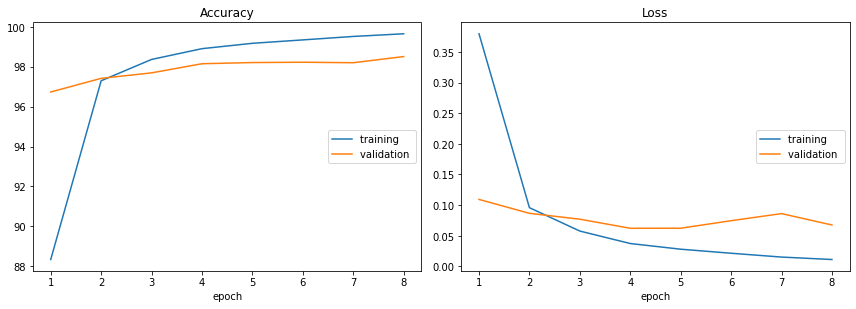

Accuracy
	training         	 (min:   88.340, max:   99.650, cur:   99.650)
	validation       	 (min:   96.733, max:   98.508, cur:   98.508)
Loss
	training         	 (min:    0.011, max:    0.379, cur:    0.011)
	validation       	 (min:    0.062, max:    0.109, cur:    0.068)
Epoch 00008: early stopping
Test:
	Loss:  0.054
	Accuracy:  98.700


In [32]:
# Let the Fancy training loop start! 
# Make sure to Turn the GPU ON
fancy_poutyne_train(model_name='mnist3', pytorch_model=mnist3)

Thanks to LiveLossPlot, we can see all the fancy graphs now!  

_**You can now do a little experiment and see for yourself how the model starts  
to overfit. Simply remove the Early Stopping callback from the training loop.**_

<br/>You can see your model overfit even on such a simple dataset! 

###10. Inference  
We have a trained model in our hands now.  
We would now like to write a simnple inference routine where we can enjoy  
the predictions of our PyTorch Model! 

In [0]:
# A rather straightforward inference routine 

def inference():
    PATH = 'mnist3_last_epoch.ckpt' # Path to the saved model checkpoint

    # Load the model 
    model = MNISTModel1().to('cpu') # Instantiate our PyTorch model 
    model.load_state_dict(torch.load(PATH)) # Load the saved model 
    # summary(model, (1, 28, 28), device='cpu') # Check if everything is correct 

    # Time to get some 'test_loader' data for our model 
    dataiter = iter(train_loader) # Get the whole batch 
    images, labels = dataiter.next() # Extract the images and their labels 
    label = labels[0] # The ground truth

    # Images need a little bit of processing! 
    image = images[0] # Take the first image from the batch = 1 x 28 x 28
    # Remember that our Model expects the first dimension as a 'batch size' 
    # Therefore, we add one extra dimension in the 'start.  
    image = torch.unsqueeze(image, dim=0) # 1 x 1 x 28 x 28 (batch_size = 1)
    print('\nimage.shape =>', image.shape)

    # Disable the autograd module 
    with torch.no_grad(): # no need to calculate the gradients as we are not training
        # Make a forward-pass 
        output = model.forward(image)
    
    # Our model outputs 'logits', we need to transform it into class probabilities. 
    # https://discuss.pytorch.org/t/how-to-extract-probabilities/2720/12
    # To transform logits, we need to use the 'Softmax' function
    # https://medium.com/data-science-bootcamp/understand-the-softmax-function-in-minutes-f3a59641e86d
    # Therefore,  
    class_probabilities = F.softmax(output, dim=1).numpy().squeeze()
    print('\nClass Probabilities ==>', class_probabilities)
    for i, proba in enumerate(class_probabilities):
        print(f'Class \t{i}\t Probability \t{100*proba:.2f}%')

    # A very Fancy way to showcase the results 
    # Create a figure with two axes, ax1 and ax2
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2) # Subplot with 2 columns
    # ax1 holds the image from the test dataset
    ax1.imshow(image.resize_(1, 28, 28).numpy().squeeze())
    ax1.set_title('Ground Truth ' + str(label.numpy()))
    # ax2 holds a horizontal bar chart containing class_probabilities 
    ax2.barh(np.arange(10), class_probabilities)
    ax2.set_aspect(0.1) # aspect ratio of ax2, else it will get too big
    ax2.set_yticks(np.arange(10)) # 10 ticks on the y-axis for 10 classes
    ax2.set_yticklabels(np.arange(10)) # set the ticklabels from 0 to 9
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1) # probability can't be over 1, hence set limit to 1.1

    return None


image.shape => torch.Size([1, 1, 28, 28])

Class Probabilities ==> [1.08e-08 2.75e-05 1.00e+00 2.00e-06 1.42e-08 1.08e-08 1.08e-08 4.59e-07 1.08e-08 1.08e-08]
Class 	0	 Probability 	0.00%
Class 	1	 Probability 	0.00%
Class 	2	 Probability 	100.00%
Class 	3	 Probability 	0.00%
Class 	4	 Probability 	0.00%
Class 	5	 Probability 	0.00%
Class 	6	 Probability 	0.00%
Class 	7	 Probability 	0.00%
Class 	8	 Probability 	0.00%
Class 	9	 Probability 	0.00%


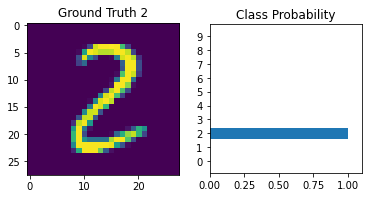

In [34]:
inference() 

###11. Thank You!  
Guys, thank you so much for being with me through this webinar.  
I would like to thank each and every one of you out there!  

I will be really happy to connect with you all on LinkedIN, feel free to drop  
in a connection request. 
 
https://www.linkedin.com/in/pranjall/

###12. BONUS! 

I will be adding some bonus content in this Notebook in the coming week.  
Namely,  
1. Transfer Learning  
2. Visualizing computation graphs of your custom model  
3. Visualizing what your CNN layer is looking at (it is amazing, trust me!)  

Consider _**starring**_ this repository on Github if you liked this webinar  
and want to get the bonus material coming later in this week.  
A lot of my peers at Udacity have loved the content in this repo, checkout the  
`Introduction to Neural Networks` folder.  

I plan to keep uploading/updating the content of all of my future webinars in   
this repository. 

https://github.com/pranjalchaubey/Deep-Learning-Notes  

_**Wishing you guys all the best in your Deep Learning journey with PyTorch!**_ 